Let's plot the historical (30 years) average HDD

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import math

In [4]:
us_base_hdd = pd.read_csv('files/base.csv')
us_base_hdd = us_base_hdd.rename(columns={'Unnamed: 0': 'Day of year'})
us_base_hdd = us_base_hdd.set_index('Day of year')

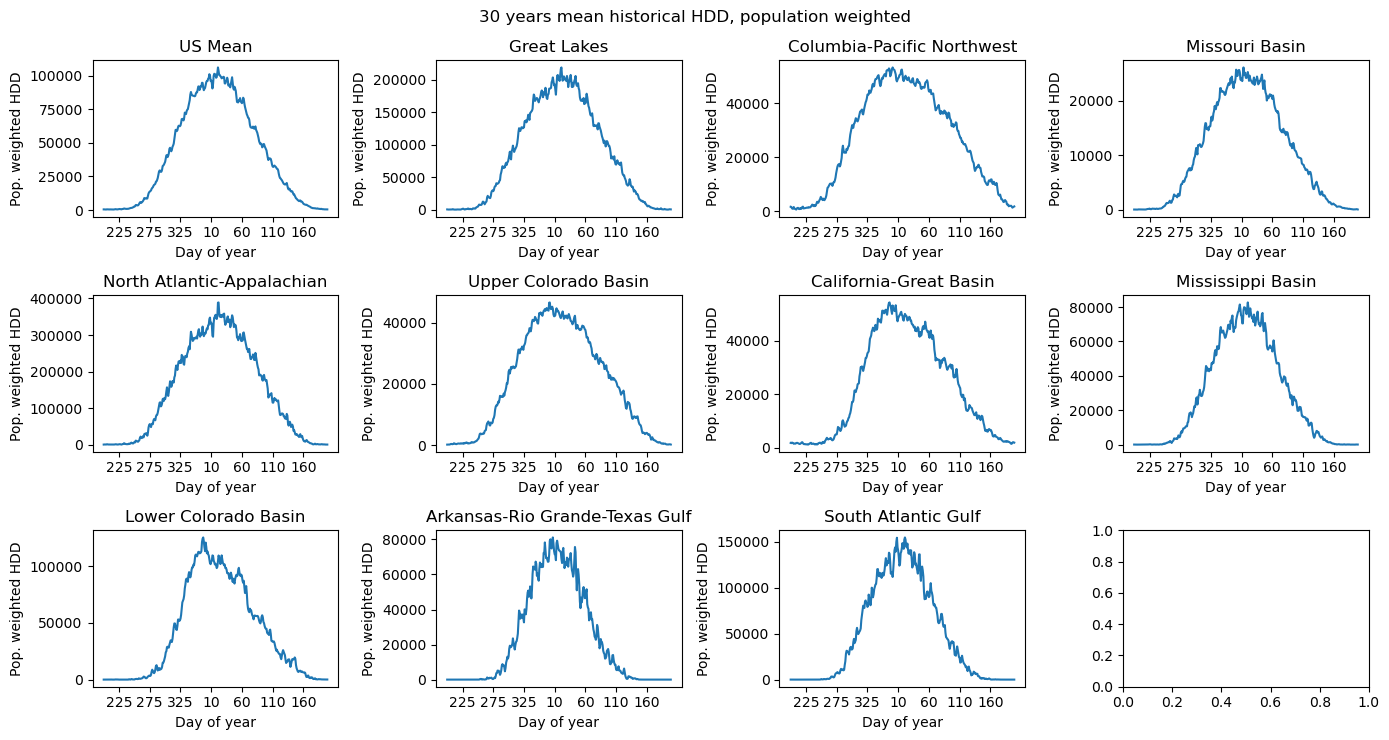

In [6]:
us_base_hdd_rearranged = pd.concat([us_base_hdd.loc[200:365], us_base_hdd.loc[0:199]]) #rearrange the index for a better plot

cols = 4
rows = math.ceil(len(us_base_hdd_rearranged.columns) / cols)

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 2.5 * rows))
ax = ax.flatten()

tick_positions = range(25, len(us_base_hdd_rearranged), 50)  #Every 50 days
tick_labels = [us_base_hdd_rearranged.index[pos] for pos in tick_positions]

for i, col in enumerate(us_base_hdd_rearranged.columns):
    ax[i].plot(us_base_hdd_rearranged[col].values)
    ax[i].set_title(f'{col}')
    ax[i].set_xticks(tick_positions)
    ax[i].set_xticklabels(tick_labels)
    ax[i].set_xlabel('Day of year')
    ax[i].set_ylabel('Pop. weighted HDD')
plt.suptitle('30 years mean historical HDD, population weighted')
plt.tight_layout()
plt.show()